In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.pyplot import figure

# Function Definitions

## Time Delay Neural Network

In [2]:
import torch.nn.functional as F

class TDNN(nn.Module):
    def __init__(self, delay, hidden_layers, hidden_dim, out_dim):
        super().__init__()
        
        self.delay = delay
        
        layers = [nn.Linear(delay, hidden_dim), nn.ReLU()]
        
        for i in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, out_dim))
        
        self.sequential = nn.Sequential(*layers)
        
    def forward(self, x):
        pad = torch.zeros(self.delay-1)
        input_ = torch.cat([pad, x]).unfold(dimension=0, size=self.delay, step=1)
        
        return self.sequential(input_)

In [3]:
def construct_tdnn_data(X, t=2):
    data = []
    input_i = [0 for _ in range(t)]
    for x in X:
        input_i.pop(0)
        input_i.append(x)
        
        data.append(torch.Tensor(input_i))
        
    return torch.stack(data)

In [4]:
def evaluate(model, X_valid, y_valid, loss_fn):
    model.eval()
    
    with torch.no_grad():

        y_pred = model(X_valid)
        loss = loss_fn(y_pred.view(-1), y_valid.view(-1))
        
    return loss.item()

In [5]:
def train(X_train, y_train, X_valid, y_valid, window_size, hidden_dim, learning_rate, num_epochs):
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    
    X_valid = torch.Tensor(X_valid)
    y_valid = torch.Tensor(y_valid)

    model = TDNN(window_size, 2, hidden_dim, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    train_losses = []
    valid_losses = []
    

    for i in tqdm(range(num_epochs)):
        model.train()

        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()

        train_losses.append(train_loss)
    
        valid_losses.append(evaluate(model, X_valid, y_valid, loss_fn))
    
    return train_losses, valid_losses, model

In [6]:
import itertools

def grid_search(grid, X_train, y_train, X_valid, y_valid):
    
    best_loss = np.inf
    best_params = None
    best_train_losses = None
    best_valid_losses = None
    
    for (window_size, hidden_dim, learning_rate, num_epochs) in itertools.product(*grid.values()):
        
        train_losses, valid_losses, _ = train(X_train, y_train, X_valid, y_valid, window_size, hidden_dim, learning_rate, num_epochs)
        
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            best_params = (window_size, hidden_dim, learning_rate, num_epochs)
            best_train_losses = train_losses
            best_valid_losses = valid_losses

        print(" -- finished", (window_size, hidden_dim, learning_rate, num_epochs), "loss", valid_losses[-1])
            
    print("finished grid search, the best are:", best_params)
        
    return best_train_losses, best_valid_losses, best_params

In [7]:
def predict(X, model):
    return model(torch.Tensor(X)).view(-1).detach()

## RNN

In [8]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, act_fn='tanh'):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, nonlinearity=act_fn)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h0):
        out, hn = self.rnn(x, h0)
        
        out = self.fc(out)
        return out, hn

In [9]:
def evaluate_rnn(model, X_valid, y_valid, hidden_state, loss_fn):
    model.eval()
    
    valid_loss = 0.0
    
    y_pred, hidden_state = model(X_valid, hidden_state)
    loss = loss_fn(y_pred.view(-1), y_valid.view(-1))

    return loss.item()

In [10]:
def train_rnn(X_train, y_train, X_valid, y_valid, hidden_dim, learning_rate, num_epochs):
    X_train = torch.Tensor(X_train).reshape((X_train.shape[0], 1, 1))
    y_train = torch.Tensor(y_train).reshape((y_train.shape[0], 1, 1))
    
    X_valid = torch.Tensor(X_valid).reshape((X_valid.shape[0], 1, 1))
    y_valid = torch.Tensor(y_valid).reshape((y_valid.shape[0], 1, 1))

    model = RNNModel(1, hidden_dim, 2, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    train_losses = []
    valid_losses = []

    for i in tqdm(range(num_epochs)):

        valid_loss = 0.0
        train_loss = 0.0
        model.train()

        hidden_state = torch.zeros(2, 1, hidden_dim)

        optimizer.zero_grad()
        y_pred, hidden_state = model(X_train, hidden_state)
        loss = loss_fn(y_pred.view(-1), y_train.view(-1))
        loss.backward()
        optimizer.step()
        hidden_state = hidden_state.detach()

        train_loss += loss.item()

        train_losses.append(train_loss)
        valid_losses.append(evaluate_rnn(model, X_valid, y_valid, hidden_state, loss_fn))

    return train_losses, valid_losses, model

In [11]:
def grid_search_rnn(grid, X_train, y_train, X_valid, y_valid):
    
    best_loss = np.inf
    best_params = None
    best_train_losses = None
    best_valid_losses = None
    
    for (hidden_dim, learning_rate, num_epochs) in itertools.product(*grid.values()):
        
        train_losses, valid_losses, _ = train_rnn(X_train, y_train, X_valid, y_valid, hidden_dim, learning_rate, num_epochs)
        
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            best_params = (hidden_dim, learning_rate, num_epochs)
            best_train_losses = train_losses
            best_valid_losses = valid_losses

        print(" -- finished", (hidden_dim, learning_rate, num_epochs), "loss", valid_losses[-1])
            
    print("finished grid search, the best are:", (hidden_dim, learning_rate, num_epochs))
    
    return best_train_losses, best_valid_losses, (hidden_dim, learning_rate, num_epochs)

In [34]:
def predict_rnn(model, X, hidden_dim):
    X = torch.Tensor(X).reshape((X.shape[0], 1, 1))
    hidden_state = torch.zeros(2, 1, hidden_dim)
    y, _ = model(X, hidden_state)
    return y.view(-1).detach()

# NARMA10

In [13]:
data_narma10 = pd.read_csv("data/NARMA10.csv", header=None)

In [14]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [15]:
X = data_narma10.values[0, :]
y = data_narma10.values[1, :]

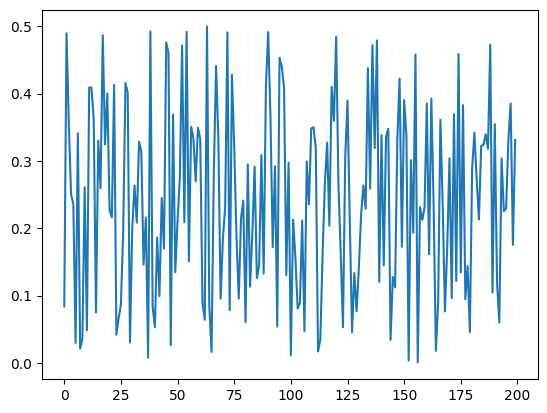

In [16]:
plt.plot(X[:200])
plt.show()

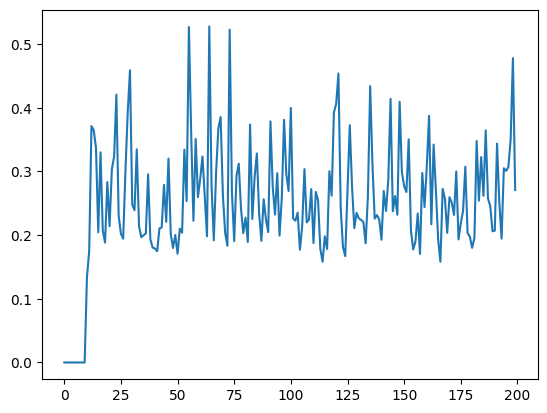

In [17]:
plt.plot(y[:200])
plt.show()

## TDNN

In [18]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [19]:
grid = {
    "window_size" : [10],
    "hidden_dim" : [256],
    "learning_rate" : [1e-3],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 76.09it/s]

 -- finished (10, 256, 0.001, 200) loss 0.004756107926368713
finished grid search, the best are: (10, 256, 0.001, 200)


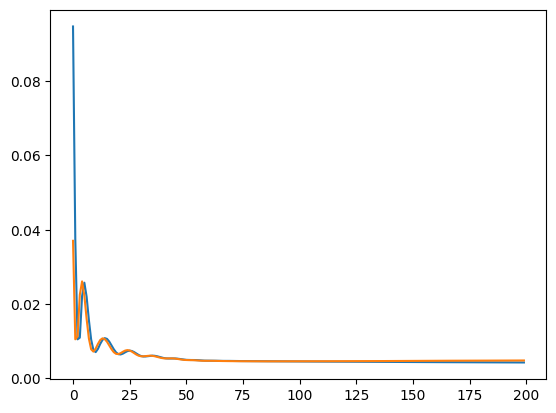

In [20]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [21]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [22]:
window_size, hidden_dim, learning_rate, num_epochs = best_params
train_losses, test_losses, model = train(X_train, y_train, X_test, y_test, window_size, hidden_dim, learning_rate, num_epochs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 48.64it/s]


In [23]:
print(train_losses[-1])
print(test_losses[-1])

0.0043463436886668205
0.004300120752304792


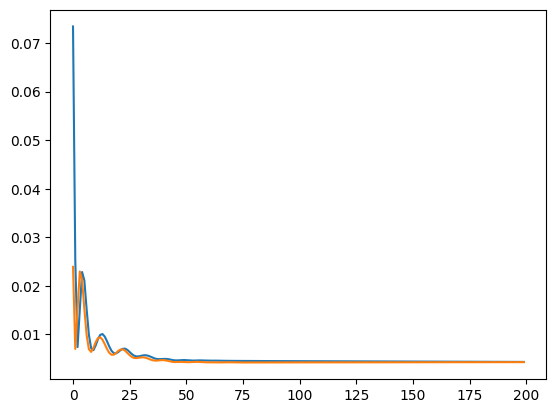

In [24]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

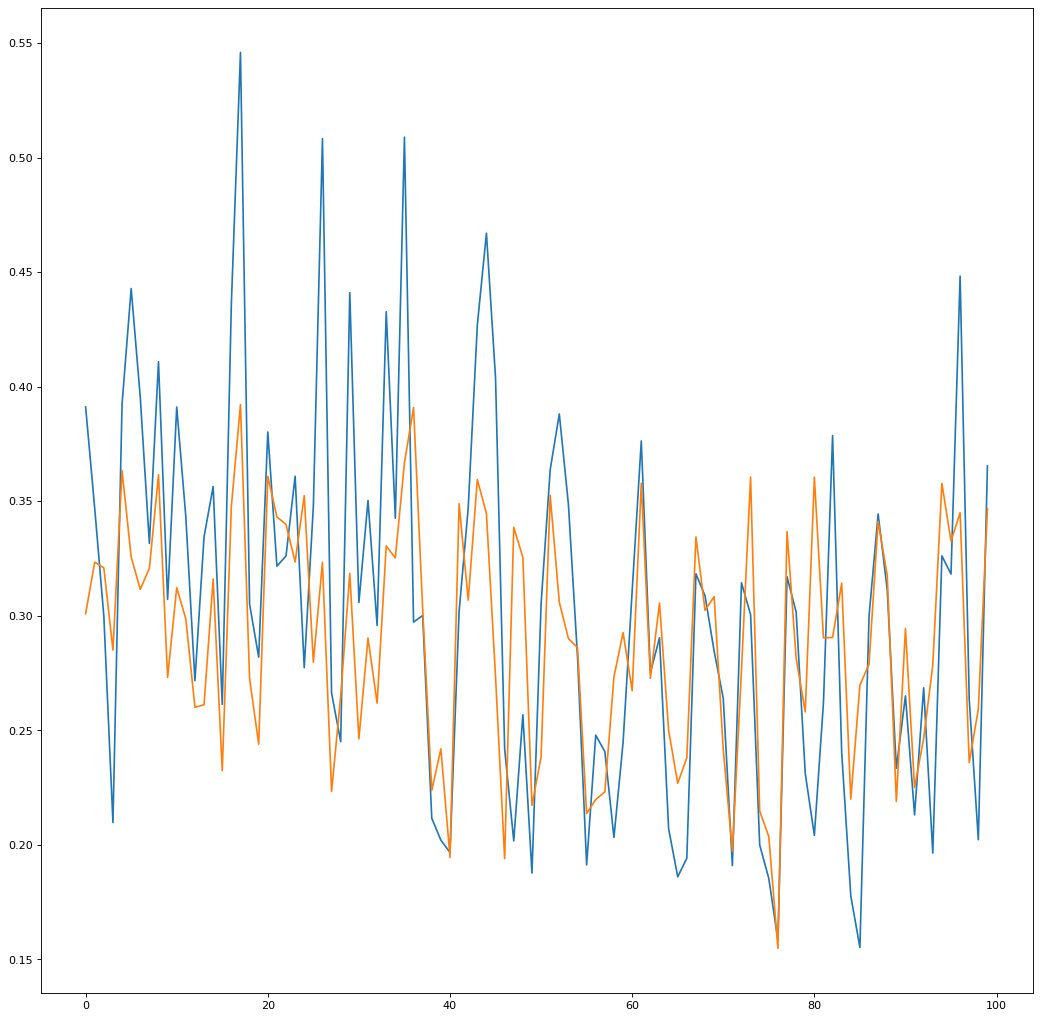

In [25]:
figure(figsize=(16, 16), dpi=80)
y_pred = predict(X, model)
plt.plot(y[-100:])
plt.plot(y_pred[-100:])
plt.show()

## RNN

In [26]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [27]:
grid = {
    "hidden_dim" : [256],
    "learning_rate" : [1e-3],
    "num_epochs" : [100]
}

train_losses, valid_losses, (hidden_dim, learning_rate, num_epochs) = grid_search_rnn(grid, X_train, y_train, X_valid, y_valid)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]

 -- finished (256, 0.001, 100) loss 0.002901053288951516
finished grid search, the best are: (256, 0.001, 100)


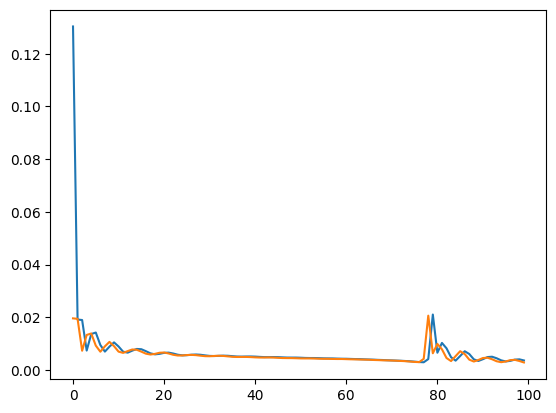

In [28]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [29]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [30]:
train_losses, valid_losses, model = train_rnn(X_train, y_train, X_test, y_test, hidden_dim, learning_rate, num_epochs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.01s/it]


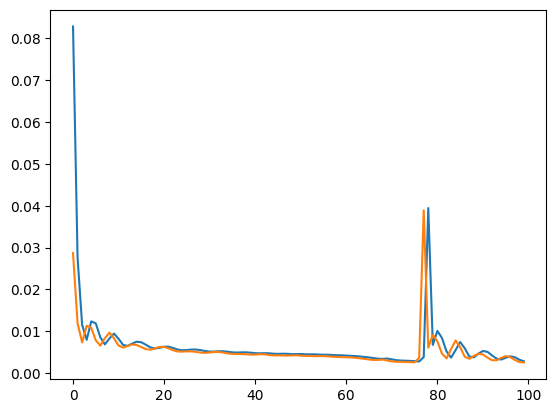

In [31]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [32]:
print(train_losses[-1])
print(valid_losses[-1])

0.002849432174116373
0.0025713767390698195


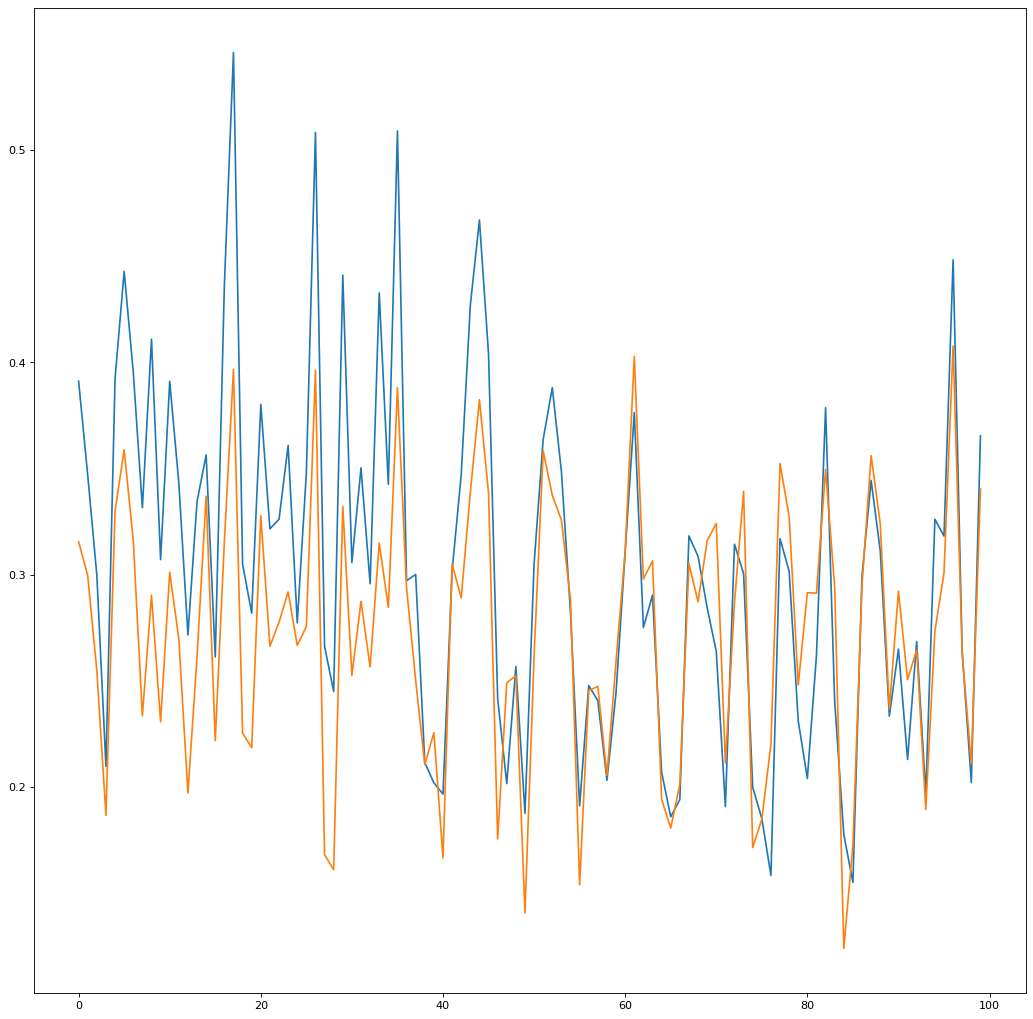

In [36]:
figure(figsize=(16, 16), dpi=80)
y_pred = predict_rnn(model, X, hidden_dim)
plt.plot(y[-100:])
plt.plot(y_pred[-100:])
plt.show()

# MG17

In [58]:
data_mg17 = pd.read_csv("data/MG17.csv", header=None)

In [59]:
data_mg17.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.032164,0.040426,0.057861,0.084015,0.11544,0.14572,0.16758,0.17624,0.17107,0.15465,...,-0.43905,-0.43957,-0.42772,-0.40213,-0.36305,-0.31286,-0.25555,-0.19556,-0.1368,-0.082192


In [64]:
data = data_narma10.values[0, :]

X = data[:-1]
y = data[1:]

In [66]:
X

array([0.083964, 0.48934 , 0.35635 , ..., 0.063013, 0.26249 , 0.44974 ])

In [67]:
y

array([0.48934 , 0.35635 , 0.25024 , ..., 0.26249 , 0.44974 , 0.054542])

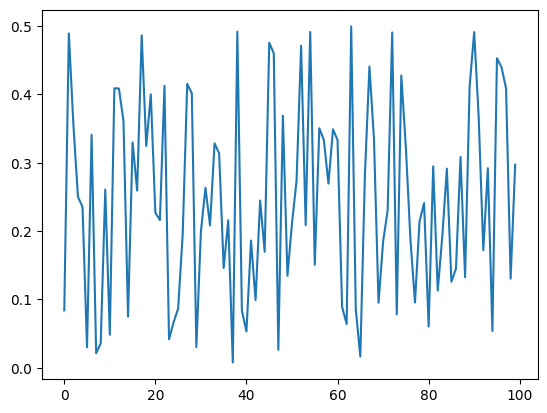

In [68]:
plt.plot(X[:100])
plt.show()

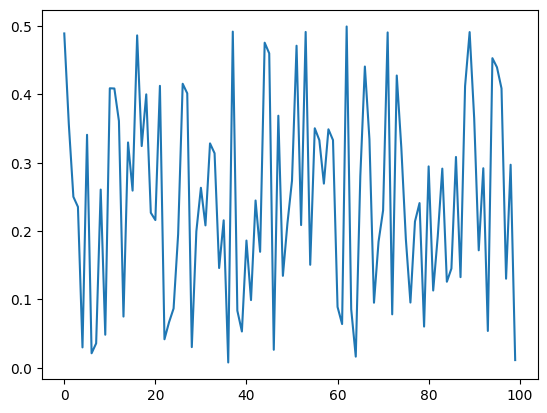

In [69]:
plt.plot(y[:100])
plt.show()

## TDNN

In [70]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [89]:
grid = {
    "window_size" : [17],
    "hidden_dim" : [256],
    "learning_rate" : [1e-3],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(grid, X_train, y_train, X_valid, y_valid)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:02<00:00, 67.66it/s]

 -- finished (17, 256, 0.001, 200) loss 0.01924651674926281
finished grid search, the best are: (17, 256, 0.001, 200)


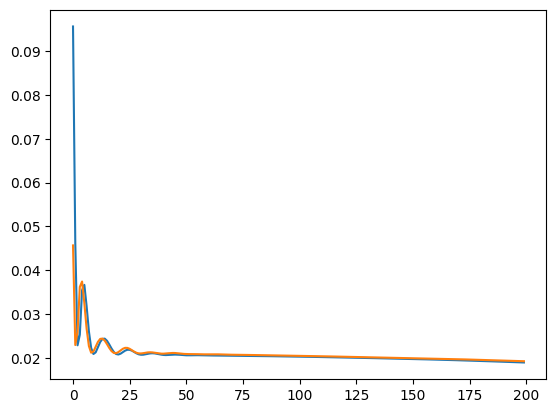

In [90]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [77]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [78]:
window_size, hidden_dim, learning_rate, num_epochs = best_params
train_losses, test_losses, model = train(X_train, y_train, X_test, y_test, window_size, hidden_dim, learning_rate, num_epochs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.64it/s]


In [79]:
print(train_losses[-1])
print(test_losses[-1])

0.020738806575536728
0.020945249125361443


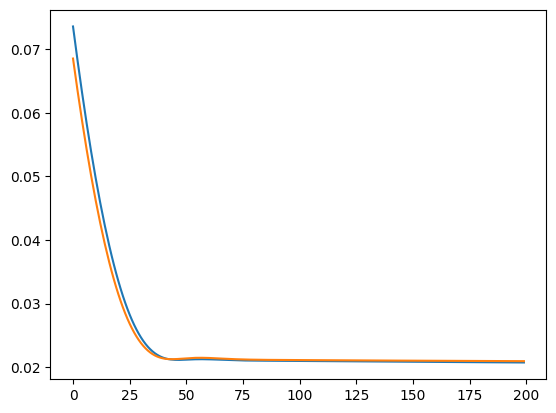

In [80]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

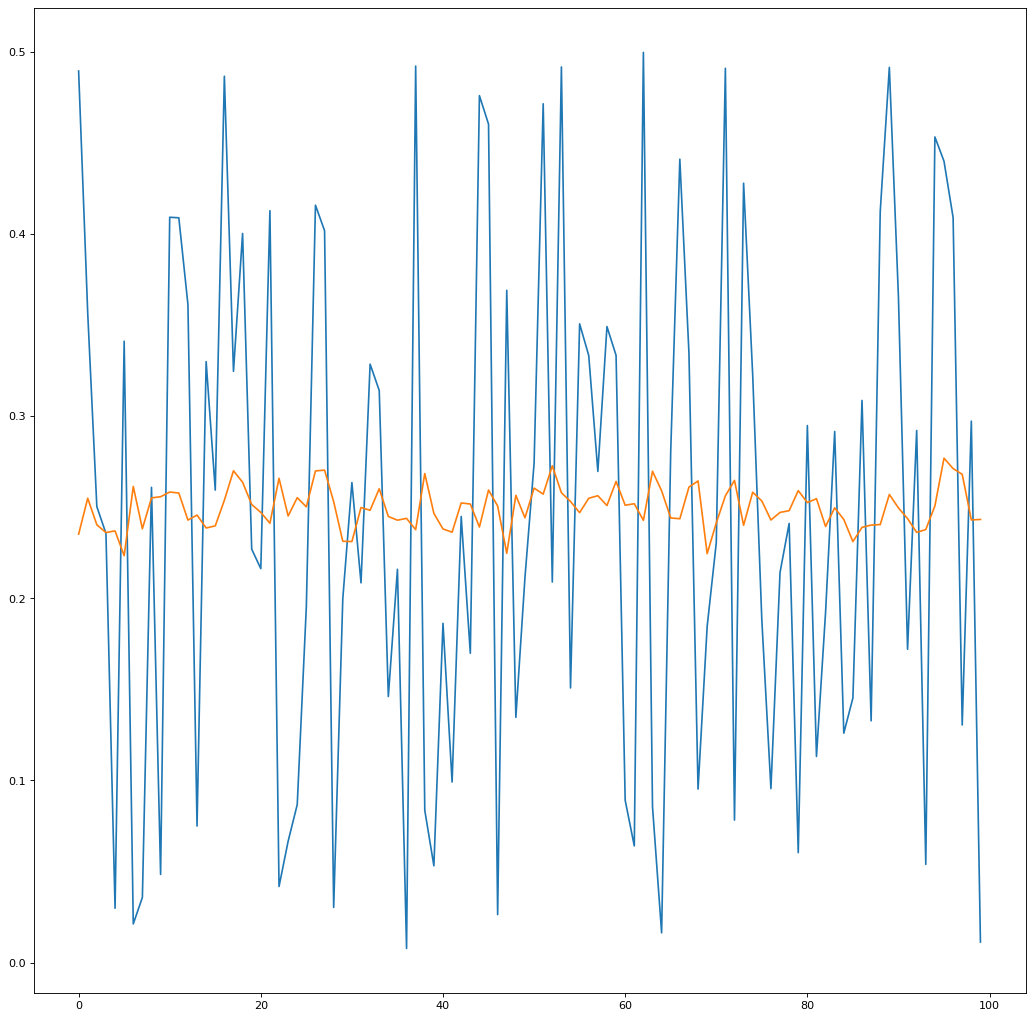

In [81]:
figure(figsize=(16, 16), dpi=80)
y_pred = predict(X, model)
plt.plot(y[:100])
plt.plot(y_pred[:100])
plt.show()

## RNN

In [50]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [51]:
grid = {
    "hidden_dim" : [256],
    "learning_rate" : [1e-3],
    "num_epochs" : [200]
}

train_losses, valid_losses, (hidden_dim, learning_rate, num_epochs) = grid_search_rnn(grid, X_train, y_train, X_valid, y_valid)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:15<00:00,  1.48it/s]

 -- finished (256, 0.001, 200) loss 0.02101798541843891
finished grid search, the best are: (256, 0.001, 200)


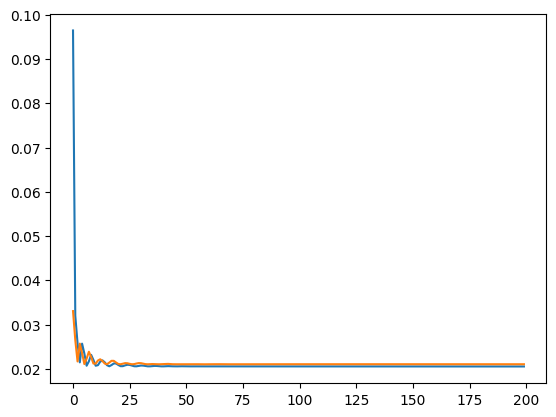

In [52]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [53]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [54]:
train_losses, valid_losses, model = train_rnn(X_train, y_train, X_test, y_test, hidden_dim, learning_rate, num_epochs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [03:22<00:00,  1.01s/it]


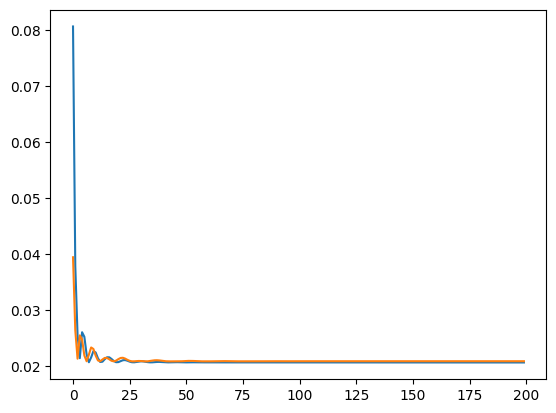

In [55]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [56]:
print(train_losses[-1])
print(valid_losses[-1])

0.020606670528650284
0.020831622183322906


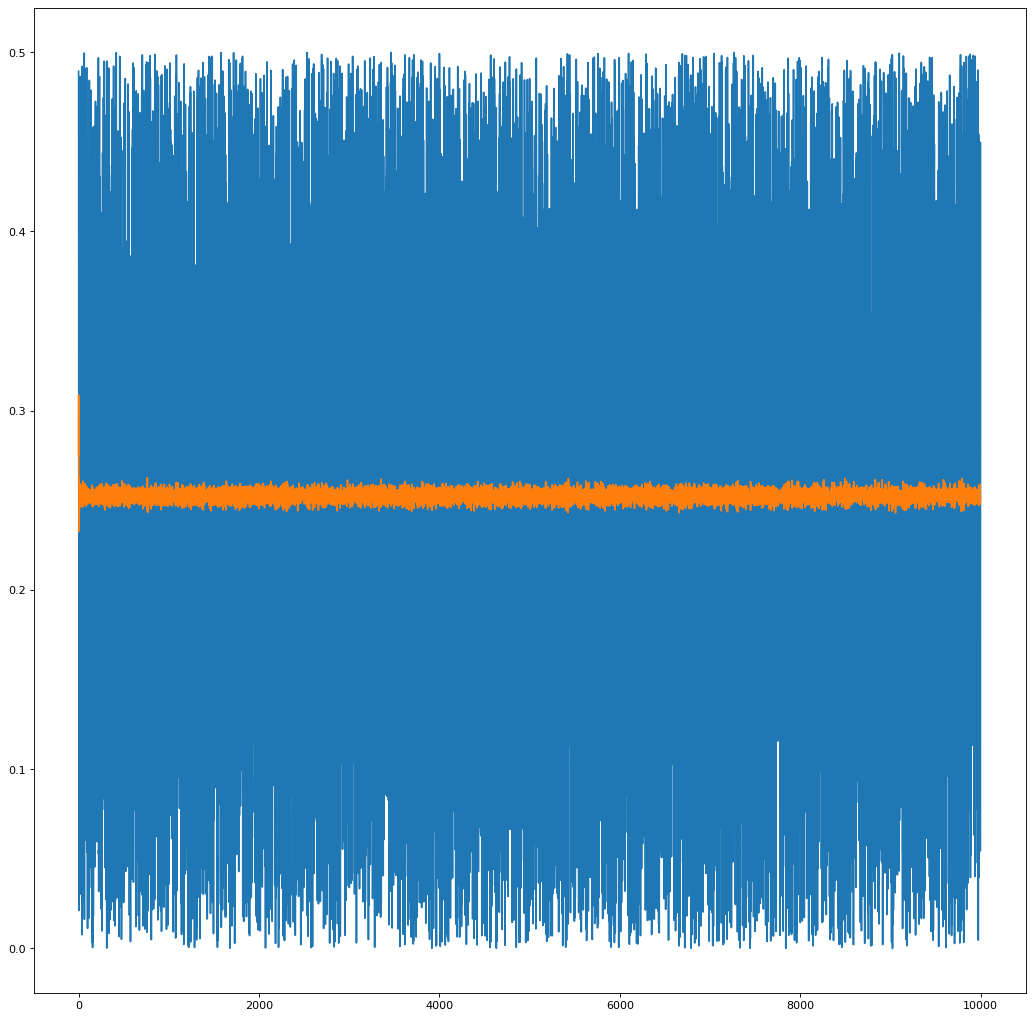

In [57]:
figure(figsize=(16, 16), dpi=80)
y_pred = predict_rnn(model, X, hidden_dim)
plt.plot(y)
plt.plot(y_pred)
plt.show()